## Fetch MNIST

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


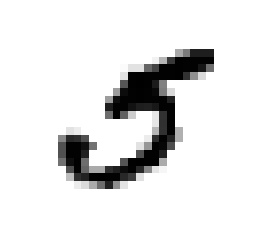

5.0


In [3]:
# visualize pics
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()
print(y[36000])

MNIST is already splitted into training set(first 60000) and test set(last 10000). 

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

## Training a binary classifier

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
## SGCclassifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42,max_iter=100,tol=1e-4)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [7]:
## evaluate performance
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.86765
0.79795
0.89925


In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.86765, 0.79795, 0.89925])

In [9]:
# dumb estimator
import numpy as np
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([1.     , 0.72895, 1.     ])

Accuracy is not a good performance measure for skewed datasets!!!

## Confusion Matrix
A much better way to evaluate the performance

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[46746,  7833],
       [  870,  4551]], dtype=int64)

## Precision and Recall

In [11]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) #precision = TP/(TP+FP)
print(recall_score(y_train_5, y_train_pred)) #recall = TP/(TP+FN)

0.36749031007751937
0.8395130049806309


In [12]:
# F1 score, harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.5112047177759056

In [13]:
# decision func
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold=0 # threshold 0
y_some_digit_pred = (y_scores>threshold)
print(y_some_digit_pred)

[ True]


In [14]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

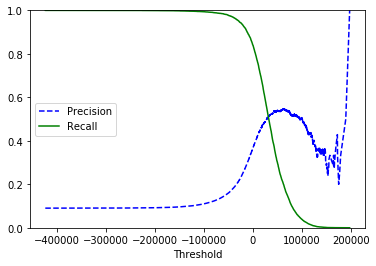

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precision, recalls, threshold):
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

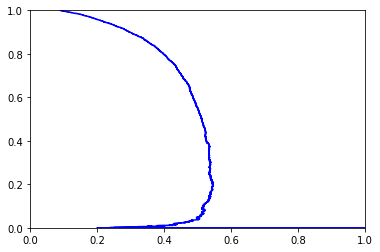

In [16]:
# precision vs recall
plt.plot(precisions[:-1], recalls[:-1],'b-')
plt.ylim([0,1])
plt.xlim([0,1])
plt.show()

In [17]:
# set threshold = 20000
y_train_pred_90 = (y_scores > 20000)
precision_score(y_train_5, y_train_pred_90)

0.47441735869274043

## The ROC curve
ROC = true positive rate/false positive rate (sensitivity/1-specificity)

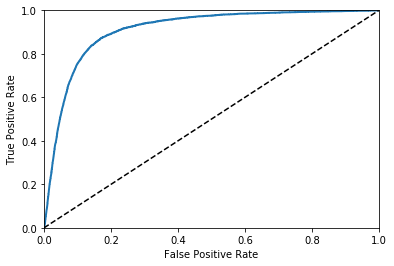

In [18]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.91022636524642

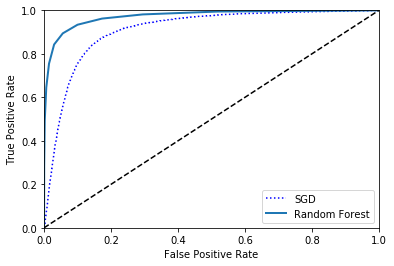

In [20]:
## Train a RandomForest
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
# use the positive class's probability as the score
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshods_forest = roc_curve(y_train_5, y_scores_forest)
## plot ROC curve
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [21]:
print(roc_auc_score(y_train_5, y_scores_forest))
RF_y_predict = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, RF_y_predict))
print(recall_score(y_train_5, RF_y_predict))

0.9727987276449468
0.73638414437641
0.8430178933776056


## Multi-class classification

In [22]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [23]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-1.81346055e+04, -6.54968393e+04, -5.17560111e+04,
        -6.73699290e+04, -3.93255066e+04,  8.73255224e+01,
        -1.33206157e+05, -6.18094456e+04, -4.83492166e+04,
        -5.53580029e+04]])

In [24]:
# force ovo
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [25]:
len(ovo_clf.estimators_)

45

In [26]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [27]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [28]:
# cross validation evaluation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87352529, 0.86674334, 0.86683002])

In [29]:
# scaling improves performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

C:\Users\zxj19\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\zxj19\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\zxj19\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90826835, 0.9100955 , 0.91308696])

## Error Analysis

In [30]:
# Confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\zxj19\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\zxj19\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\zxj19\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5663,    1,   27,   10,   11,   63,   45,    7,   92,    4],
       [   1, 6449,   44,   31,    6,   48,    4,    9,  136,   14],
       [  35,   30, 5347,  104,   73,   33,   73,   46,  205,   12],
       [  35,   25,  136, 5340,    3,  242,   29,   47,  187,   87],
       [  14,   15,   51,   12, 5301,   12,   49,   30,  143,  215],
       [  44,   24,   41,  194,   57, 4621,   83,   20,  253,   84],
       [  31,   18,   52,    2,   39,  104, 5600,    3,   68,    1],
       [  21,   12,   67,   39,   55,   10,    3, 5759,   45,  254],
       [  30,   91,   61,  111,    9,  143,   38,   15, 5266,   87],
       [  30,   23,   32,   82,  128,   40,    1,  186,  144, 5283]],
      dtype=int64)

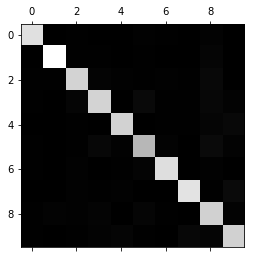

In [31]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

<function matplotlib.pyplot.show>

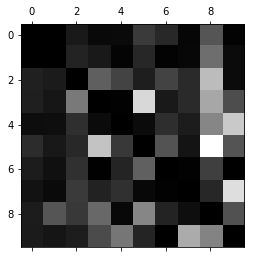

In [32]:
row_sums = conf_mx.sum(axis = 1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show

In [37]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

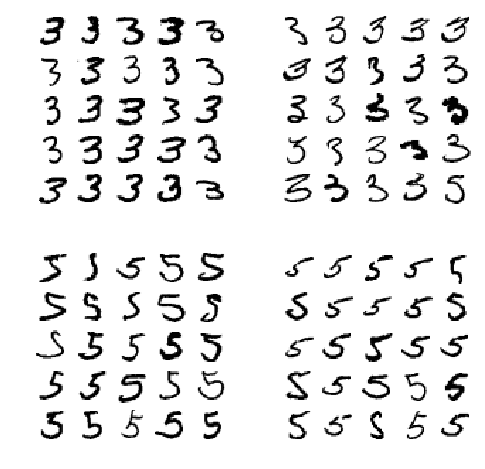

In [38]:
## show 3s and 5s
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel classification

In [39]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

## Multioutput classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)